In [88]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd

col_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
              'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
              'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
              'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
              'num_access_files', 'num_outbound_cmds', 'is_host_login',
              'is_guest_login', 'count', 'srv_count', 'serror_rate',
              'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
              'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
              'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 
              'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
              'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
              'dst_host_srv_rerror_rate', 'attack_type'] #41 feature, 3u kategorik, 1 etiket

train_data = pd.read_csv("/content/drive/My Drive/NSL-KDD/NSL_KDD_Train.csv",header=None, names = col_names)
#test_data = pd.read_csv("/content/drive/My Drive/NSL-KDD/NSL_KDD_Test_21.csv", header=None, names = col_names,sep=",")
test_data = pd.read_csv("/content/drive/My Drive/NSL-KDD/NSL_KDD_Test.csv", header=None, names = col_names)

from sklearn.preprocessing import LabelEncoder
#from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import Normalizer




label_encoder = LabelEncoder()
for column in ['protocol_type','service','flag']:
  label_encoder.fit(train_data[column])
  train_data[column] = label_encoder.transform(train_data[column])

label_encoder = LabelEncoder()
for column in ['protocol_type','service','flag']:
  label_encoder.fit(test_data[column])
  test_data[column] = label_encoder.transform(test_data[column])

dos_attacks = ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm']
probe_attacks = ['ipsweep','mscan','nmap','portsweep','saint','satan']
privilege_attacks = ['buffer_overflow','loadmdoule','perl','ps','rootkit','sqlattack','xterm'] #U2R
access_attacks = ['ftp_write','guess_passwd','http_tunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xclock','xsnoop']

def map_attack(attack):
    if attack in dos_attacks:
        attack_type = 1
    elif attack in probe_attacks:
        attack_type = 2
    elif attack in privilege_attacks: #U2R
        attack_type = 3
    elif attack in access_attacks: #R2L
        attack_type = 4
    else:
        attack_type = 0
        
    return attack_type  

attack_map = train_data.attack_type.apply(map_attack)
train_data['attack_type'] = attack_map
attack_map = test_data.attack_type.apply(map_attack)
test_data['attack_type'] = attack_map
 
#train_df, test_df = train_test_split(df)

X = train_data.iloc[:,0:41]
Y = train_data.iloc[:,41]
T = test_data.iloc[:,0:41]
C = test_data.iloc[:,41]

trainX = np.array(X)
testT = np.array(T)

trainX.astype(float)
testT.astype(float)

y_train1 = np.array(Y)
y_test1= np.array(C)
y_train= to_categorical(y_train1)
y_test= to_categorical(y_test1)

scaler = Normalizer().fit(trainX)
trainX = scaler.transform(trainX)

scaler = Normalizer().fit(testT)
testT = scaler.transform(testT)

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import SimpleRNN
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

METRICS = [
      tf.keras.metrics.Accuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

import tensorflow.keras.backend as K
def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*((prec*rec)/(prec+rec+K.epsilon()))

rnn_X_train = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
rnn_X_test = np.reshape(testT, (testT.shape[0], 1, testT.shape[1]))

rnn_model = Sequential()
rnn_model.add(SimpleRNN(64,input_dim=41, return_sequences=True))
rnn_model.add(Dropout(0.1))
rnn_model.add(SimpleRNN(64,return_sequences=True))
rnn_model.add(Dropout(0.1))
rnn_model.add(SimpleRNN(64, return_sequences=True))
rnn_model.add(Dropout(0.1))
rnn_model.add(SimpleRNN(64, return_sequences=False))
rnn_model.add(Dropout(0.1))
rnn_model.add(Dense(5, activation="softmax"))



rnn_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy', 'mae', recall,precision,f1_score])



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
from imblearn.under_sampling import NearMiss
under_sampler = NearMiss()
nsamples, nx, ny = rnn_X_train.shape
rnn_X_train = rnn_X_train.reshape((nsamples,nx*ny))
X_res, y_res = under_sampler.fit_resample(rnn_X_train, y_train)


In [ ]:
from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler(random_state=42)
nsamples, nx, ny = rnn_X_train.shape
rnn_X_train = rnn_X_train.reshape((nsamples,nx*ny))
X_res, y_res = over_sampler.fit_resample(rnn_X_train, y_train)

In [78]:
from imblearn.under_sampling import RandomUnderSampler
under_sampler = RandomUnderSampler(random_state=42)
nsamples, nx, ny = rnn_X_train.shape
rnn_X_train = rnn_X_train.reshape((nsamples,nx*ny))
X_res, y_res = under_sampler.fit_resample(rnn_X_train, y_train)


In [ ]:
from imblearn.over_sampling import SMOTE
over_sampler = SMOTE(k_neighbors=2)
nsamples, nx, ny = rnn_X_train.shape
rnn_X_train = rnn_X_train.reshape((nsamples,nx*ny))
X_res, y_res = over_sampler.fit_resample(rnn_X_train, y_train)

In [ ]:
rnn_history = rnn_model.fit(rnn_X_train, y_train, batch_size=64, epochs=30, verbose = 0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


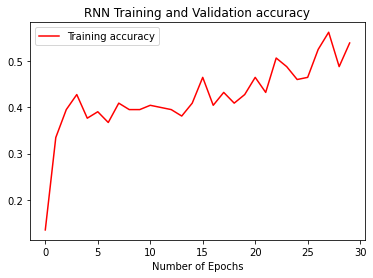

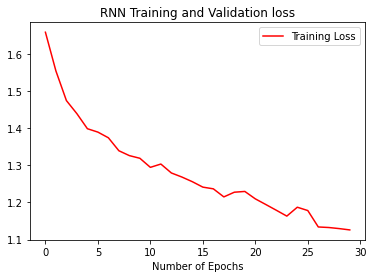

705/705 [==============================] - 29s 41ms/step - loss: 1.4893 - accuracy: 0.4740 - mae: 0.2827 - recall: 0.0697 - precision: 1.0000 - f1_score: 0.1299
Training Accuracy:  0.42310077796379725
Accuracy:  0.47400638461112976 
Loss:  1.4892609119415283
              precision    recall  f1-score   support

           0       0.97      0.27      0.42      9855
           1       0.51      0.92      0.66      7460
           2       0.33      0.36      0.34      2421
           3       0.01      0.12      0.02        65
           4       0.12      0.12      0.12      2743

    accuracy                           0.47     22544
   macro avg       0.39      0.36      0.31     22544
weighted avg       0.64      0.47      0.45     22544



In [87]:
#rnn_history = rnn_model.fit(rnn_X_train, y_train, batch_size=64, epochs=10, validation_data=(rnn_X_test, y_test), verbose = 0)
#rnn_history = rnn_model.fit(rnn_X_train, y_train, batch_size=64, epochs=2, verbose = 0)
#sample = X_res.shape[0]  ----
#features = X_res.shape[1] ----
#x_train = np.reshape(X_res,(sample,features,1)) ----
#x_test = np.reshape(X_res,(X_res.shape[0],X_res.shape[1],1))
#sample = X_res.shape[0]
#features = X_res.shape[1]
#X_res = np.reshape(X_res,(sample,features,1)) ----
#x = np.reshape(X_res,(X_res.shape[0],X_res.shape[1],1))
X_res = np.reshape(X_res, (X_res.shape[0], 1, X_res.shape[1]))
import tensorflow as tf
tf.config.run_functions_eagerly(True)
rnn_history = rnn_model.fit(X_res, y_res, batch_size=64, epochs=30, verbose = 0)
#rnn_history = rnn_model.fit(x_train, y_res, batch_size=64, epochs=200, validation_data=(x_test, y_test), verbose = 0)

rnn_acc = rnn_history.history['accuracy']
#rnn_val_acc = rnn_history.history['val_accuracy']
rnn_loss = rnn_history.history['loss']
#rnn_val_loss = rnn_history.history['val_loss']
epochs = range(len(rnn_acc))




plt.plot(epochs, rnn_acc, 'r', label='Training accuracy')
#plt.plot(epochs, rnn_val_acc, 'b', label='Validation accuracy')
plt.title('RNN Training and Validation accuracy')
plt.xlabel("Number of Epochs")
plt.legend()
plt.show()

plt.plot(epochs, rnn_loss, 'r', label='Training Loss')
#plt.plot(epochs, rnn_val_loss, 'b', label='Validation Loss')
plt.title('RNN Training and Validation loss')
plt.xlabel("Number of Epochs")
plt.legend()
plt.show()

rnn_loss, rnn_accuracy, *c = rnn_model.evaluate(rnn_X_test, y_test)
#rnn_loss, rnn_accuracy = rnn_model.evaluate(rnn_X_test, y_test, verbose=True)
print("Training Accuracy: ",sum(rnn_acc)/len(rnn_acc))
print("Accuracy: ", rnn_accuracy, "\nLoss: ", rnn_loss)

rnn_pred = rnn_model.predict(rnn_X_test)
rnn_pred = np.argmax(rnn_pred, axis=1)
rnn_y_test = np.argmax(y_test, axis=1)
print(classification_report(rnn_y_test,rnn_pred, zero_division=0))